# Flowers EfficientNetV2B1

This Model using dataset from `tf_flowers` in Tensorflow Dataset.

Also, we use pre-trained `EfficientNetV2B1` because it has small parameter, small size model and high accuracy.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from IPython.display import Image
import seaborn as sns
import os

print(tf.__version__)

2.8.2


## Prepare the Data

### Prepare dataset

Download and Split the data into Training, Validation and Testing. The dataset is from tensorflow dataset named `tf_flowers`. More info about dataset: https://www.tensorflow.org/datasets/catalog/tf_flowers. Also we are using tfds.load to make it easier to access and dowload the dataset.

In [ ]:
(train_dir, validation_dir, test_dir), info_ds = tfds.load(
    "tf_flowers", #name of the dataset that we will use
    # Reserve 10% for validation and 10% for test
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info = True,
    shuffle_files=False,
    as_supervised=True,  # Include labels
    try_gcs = True # the dataset exists on the public GCS 
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_dir))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_dir)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_dir))


Number of training samples: 2936
Number of validation samples: 367
Number of test samples: 367


In [ ]:
# Get the dataset structure
info_ds.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

In [ ]:
# Get class names and how many class in dataset
class_names = info_ds.features['label'].names
class_names, len(class_names)

(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

### Create Directory for Saved Model

In [ ]:
# Create directory
dirName = '/Tflite_model'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  /Tflite_model  already exists


In [ ]:
# Make label.txt to use in android app later
with open('/Tflite_model/label.txt', 'w') as f:
  for i in class_names:
    f.write(i+"\n")

### Resize image

We will resize image to 240x240 to became the input_shape of model. So the `input_shape` is `(240,240,3)`

Also, we will change the `type` of image to became `float32` for the input in neural network.

In [ ]:
def resize_image(image, label):
  image = tf.image.resize(image, size=(240,240))
  image = tf.cast(image, dtype = tf.float32)
  return image, label

### Input Pipeline

we are usng input pipeline so that we can run efficiently for our model.

The `num_parallel_calls` parameter in the map() function is set to `tf.data.AUTOTUNE` which automatically tunes the mapping function to increase parallel processing efficiency

In [ ]:
train_dir = train_dir.map(map_func = resize_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dir = validation_dir.map(map_func = resize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dir = test_dir.map(map_func = resize_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Batch the data and shuffle
batch_size = 32

train_dir = train_dir.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dir = validation_dir.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dir = test_dir.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

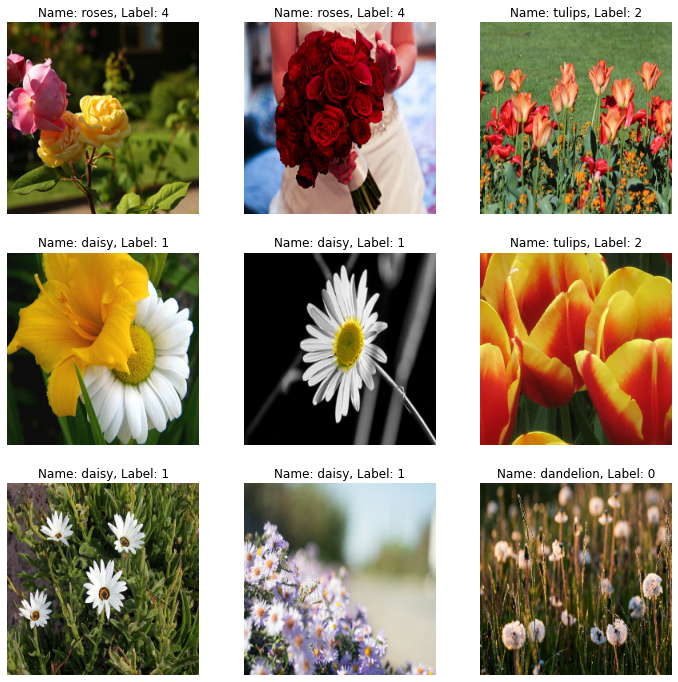

In [ ]:
# Show Image
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_dir.take(9)):
      image = image/255.
      plt.subplot(3,3,i+1)
      plt.imshow(image[0])
      plt.title("Name: " + class_names[label[0].numpy()] + 
                ", Label: " + str(label[0].numpy()))
      plt.axis("off")


In [ ]:
# element_spec attribute to check the properties of the datasets
train_dir.element_spec, validation_dir.element_spec, test_dir.element_spec,

((TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)))

### Data Augmentation

we use data augmentation because we only has little dataset. So we need more data to increase our accuracy also to prevent from overfitting.

In [ ]:
# Random Data Augmentation 

data_augmentation = keras.Sequential(
    [keras.layers.RandomFlip("horizontal_and_vertical"), 
     keras.layers.RandomRotation(0.1),
     keras.layers.RandomTranslation(0, 0.2), 
     keras.layers.RandomZoom(0.2, 0.2)
     ]
)


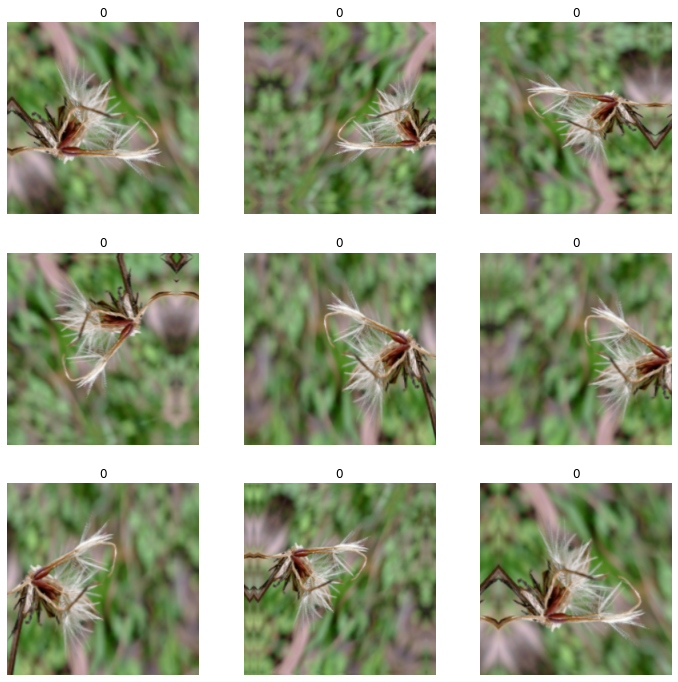

In [ ]:
# show the image after data augmentation

for images, labels in train_dir.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Callback

We use callback so that we can save the best result from our training.

In [ ]:
def model_checkpoint(directory, name):
  file_path = "/" + directory + "/" + name
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=file_path,
  save_weights_only=True,
  monitor='val_accuracy',
  verbose = 1,
  save_best_only=True)

  return model_checkpoint_callback

def early_stopping():
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="auto",
    patience = 3)
  return early_stopping_callback

## Transfer Learning

### Import Pre-trained Model

We need to download the pre-trained model if we want to use it. Because we will use in transfer learning we will not include the top of model so `include_top = False.`

In [ ]:
base_model = keras.applications.EfficientNetV2B1(
    # weights="imagenet",  # Load weights pre-trained on ImageNet.
    # input_shape=(240, 240, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

base_model.summary()

Model: "efficientnetv2-b1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

### Freeze Layers in Model


In [ ]:
# Freeze the base_model
base_model.trainable = False

### Build Model

We need to make our model include using pre-trained model, data augmentation and other layers.



In [ ]:

# Create new model on top
inputs = keras.Input(shape=(240, 240, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# pooling layers are used to down sample the volume of 
# convolution neural network by reducing the small translation of the features. 
# pooling layer also provides a parameter reduction.

x = keras.layers.Dropout(0.2)(x) # Regularize with dropout to prevent overfitting
x = keras.layers.Dense(5)(x)
# because we has 5 class for classification
outputs = keras.layers.Activation(activation="softmax", 
                                  # dtype=tf.float32
                                  )(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 efficientnetv2-b1 (Function  (None, None, None, 1280)  6931124  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405  

In [ ]:
# Check if layers is trainable or not and to check the type
for num, layer in enumerate(model.layers):
    print(num, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_2 True float32 <Policy "float32">
1 sequential True float32 <Policy "float32">
2 efficientnetv2-b1 False float32 <Policy "float32">
3 global_average_pooling2d True float32 <Policy "float32">
4 dropout True float32 <Policy "float32">
5 dense True float32 <Policy "float32">
6 activation True float32 <Policy "float32">


### Compile Model

We use SparseCategoricalCrossentropy() because we are not doing one-hot encoding.

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

### Training model for transfer learning

In [ ]:
hist_model = model.fit(train_dir,
                       epochs = 10,
                       steps_per_epoch=len(train_dir),
                       validation_data=validation_dir,
                       validation_steps=int(0.1 * len(validation_dir)),
                       callbacks=[early_stopping(), model_checkpoint("checkpoints_histmodel","model.ckpt")])

Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 0.8551 - accuracy: 0.6822
Epoch 1: val_accuracy improved from -inf to 0.84375, saving model to /checkpoints_histmodel/model.ckpt
92/92 [==============================] - 31s 182ms/step - loss: 0.8551 - accuracy: 0.6822 - val_loss: 0.5239 - val_accuracy: 0.8438
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.8355
Epoch 2: val_accuracy improved from 0.84375 to 0.90625, saving model to /checkpoints_histmodel/model.ckpt
92/92 [==============================] - 14s 136ms/step - loss: 0.4965 - accuracy: 0.8355 - val_loss: 0.3329 - val_accuracy: 0.9062
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8730
Epoch 3: val_accuracy improved from 0.90625 to 0.93750, saving model to /checkpoints_histmodel/model.ckpt
92/92 [==============================] - 11s 107ms/step - loss: 0.4104 - accuracy: 0.8730 - val_loss: 0.2712 - val_accuracy: 0.9375
Epoch 4

### Evaluate Model Accuracy

In [ ]:
# evaluate the model in test dataset
model_results = model.evaluate(test_dir)

12/12 [==============================] - 2s 118ms/step - loss: 0.1799 - accuracy: 0.9373


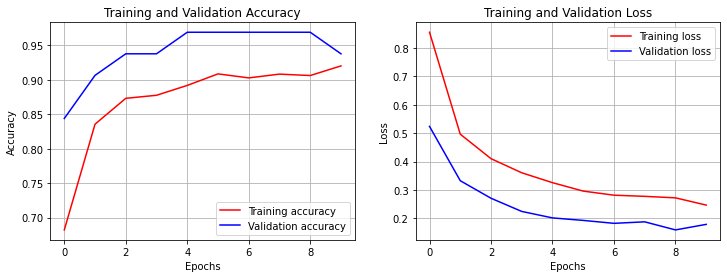

In [ ]:
# plot the accuracy and loss
plt.figure(figsize=(12,4))

# Plot 1 Accuracy
plt.subplot(1,2,1)
acc = hist_model.history['accuracy']
val_acc = hist_model.history['val_accuracy']
epochs = range(len(acc)) 

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 2 loss
plt.subplot(1,2,2)
loss = hist_model.history['loss']
val_loss = hist_model.history['val_loss']

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

## Fine-Tuning

we are doing fine-tuned to increase our model accuracy.

In [ ]:
# Make sure the EfficeintNetV2B1 is trainable
base_model.trainable = True

The `BatchNormalization` layers need to be kept `frozen`. If they are also turned to trainable, the first epoch after unfreezing will significantly reduce accuracy 

In [ ]:
for layer in model.layers[2].layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [ ]:
# check if the layers is trainable or not
for layer_number, layer in enumerate(model.layers[2].layers[-10:]):
    print(layer_number, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 block6i_se_reshape True float32 <Policy "float32">
1 block6i_se_reduce True float32 <Policy "float32">
2 block6i_se_expand True float32 <Policy "float32">
3 block6i_se_excite True float32 <Policy "float32">
4 block6i_project_conv True float32 <Policy "float32">
5 block6i_project_bn False float32 <Policy "float32">
6 block6i_add True float32 <Policy "float32">
7 top_conv True float32 <Policy "float32">
8 top_bn False float32 <Policy "float32">
9 top_activation True float32 <Policy "float32">


### Compile Fine-tuned Model Version

In [ ]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 efficientnetv2-b1 (Function  (None, None, None, 1280)  6931124  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405  

### Training Fine-tuned Model

In [ ]:
hist_model_tuned = model.fit(train_dir,
                             epochs=15,
                             steps_per_epoch=len(train_dir),
                             validation_data=validation_dir,
                             validation_steps=int(0.1*len(validation_dir)),
                             initial_epoch=hist_model.epoch[-1],                            
                             callbacks=[early_stopping(), model_checkpoint("checkpoints_histmodel_tuned", "model_tuned.ckpt")])

Epoch 10/15
92/92 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9203
Epoch 10: val_accuracy improved from -inf to 0.96875, saving model to /checkpoints_histmodel_tuned/model_tuned.ckpt
92/92 [==============================] - 43s 343ms/step - loss: 0.2210 - accuracy: 0.9203 - val_loss: 0.0686 - val_accuracy: 0.9688
Epoch 11/15
92/92 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9574
Epoch 11: val_accuracy did not improve from 0.96875
92/92 [==============================] - 29s 308ms/step - loss: 0.1203 - accuracy: 0.9574 - val_loss: 0.0462 - val_accuracy: 0.9688
Epoch 12/15
92/92 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9704
Epoch 12: val_accuracy did not improve from 0.96875
92/92 [==============================] - 29s 308ms/step - loss: 0.0818 - accuracy: 0.9704 - val_loss: 0.0647 - val_accuracy: 0.9688
Epoch 13/15
92/92 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9768
Epoc

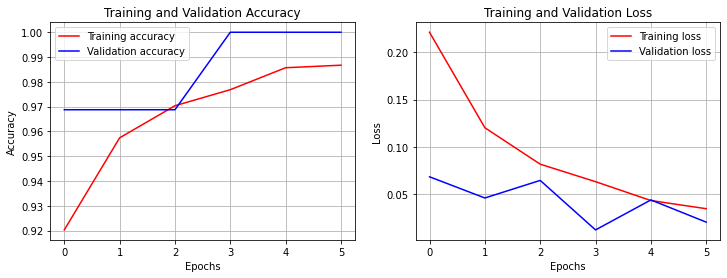

In [ ]:
# plot the accuracy and loss
plt.figure(figsize=(12,4))
# Plot 1 Accuracy
plt.subplot(1,2,1)
acc = hist_model_tuned.history['accuracy']
val_acc = hist_model_tuned.history['val_accuracy']
epochs = range(len(acc)) 

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 2 loss
plt.subplot(1,2,2)
loss = hist_model_tuned.history['loss']
val_loss = hist_model_tuned.history['val_loss']

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
model_tuned_results = model.evaluate(test_dir)

12/12 [==============================] - 1s 79ms/step - loss: 0.0784 - accuracy: 0.9782


## Predict and Testing

In [ ]:
preds = model.predict(test_dir, verbose = 1)

12/12 [==============================] - 3s 78ms/step


we can easily obtain the prediction labels using the tf.argmax() function which returns the index which contains the highest probability along a given axis.

In [ ]:
pred_labels = tf.argmax(preds, axis=1)
pred_labels[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0])>

In [ ]:
test_labels = np.concatenate([y for x, y in test_dir], axis=0)
test_labels[:10]

array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0])

### Test a Model from Capture Image

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


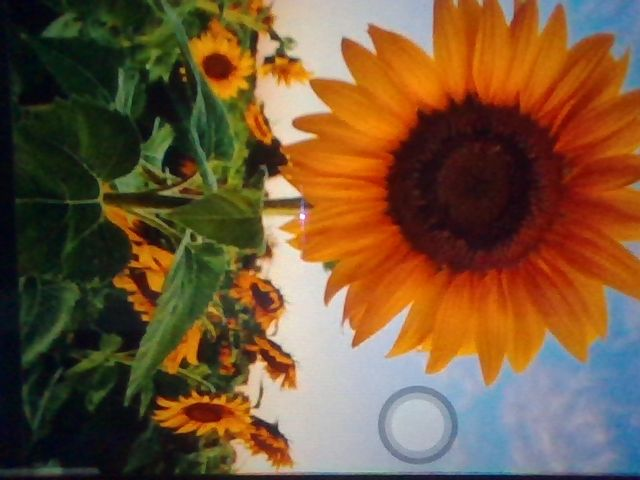

In [ ]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

This image belongs to sunflowers


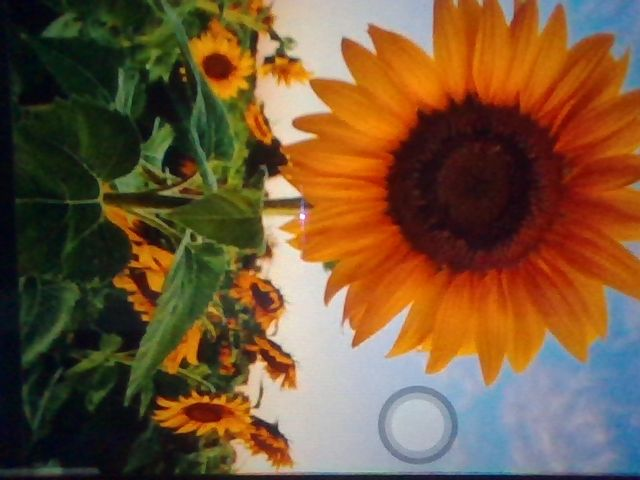

In [ ]:
image_path = '/content/photo.jpg'

img = tf.keras.utils.load_img(
    image_path, target_size=(240, 240)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image belongs to {}".format(class_names[np.argmax(score)])
)
display(Image(image_path))


## Classification Report

We will try to find classification report on our model.

In [ ]:
target_names = class_names
report = classification_report(test_labels, pred_labels, digits = 4, target_names=target_names, output_dict = True)
report

{'accuracy': 0.9782016348773842,
 'daisy': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 61},
 'dandelion': {'f1-score': 0.9857142857142858,
  'precision': 0.9857142857142858,
  'recall': 0.9857142857142858,
  'support': 70},
 'macro avg': {'f1-score': 0.9793729274460073,
  'precision': 0.9792517409847321,
  'recall': 0.979766180156273,
  'support': 367},
 'roses': {'f1-score': 0.954248366013072,
  'precision': 0.9358974358974359,
  'recall': 0.9733333333333334,
  'support': 75},
 'sunflowers': {'f1-score': 0.9868421052631579,
  'precision': 0.9868421052631579,
  'recall': 0.9868421052631579,
  'support': 76},
 'tulips': {'f1-score': 0.9700598802395209,
  'precision': 0.9878048780487805,
  'recall': 0.9529411764705882,
  'support': 85},
 'weighted avg': {'f1-score': 0.978266259594931,
  'precision': 0.9786259463936078,
  'recall': 0.9782016348773842,
  'support': 367}}

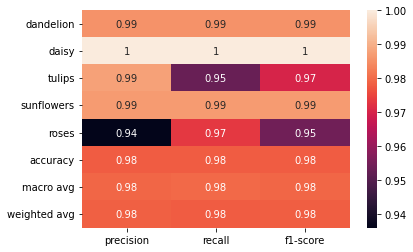

In [ ]:
# Plot classification_report
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

## Deploy Model

We will save our model and convert it to tflite android so that we can use model in our app.

### Convert to TFLite

In [ ]:
import pathlib
# Export the SavedModel
export_dir = '/Tflite_model/saved_model'
tf.saved_model.save(model, export_dir)
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

tflite_model = converter.convert()
# Save the model
tflite_model_file = pathlib.Path('/Tflite_model/flower.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /Tflite_model/saved_model/assets


INFO:tensorflow:Assets written to: /Tflite_model/saved_model/assets


27448592

### Download Saved Model and Tflite Model

In [ ]:
!zip -r /Tflite_model.zip /Tflite_model
from google.colab import files
files.download("/Tflite_model.zip")

  adding: Tflite_model/ (stored 0%)
  adding: Tflite_model/saved_model/ (stored 0%)
  adding: Tflite_model/saved_model/saved_model.pb (deflated 92%)
  adding: Tflite_model/saved_model/assets/ (stored 0%)
  adding: Tflite_model/saved_model/variables/ (stored 0%)
  adding: Tflite_model/saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: Tflite_model/saved_model/variables/variables.index (deflated 78%)
  adding: Tflite_model/flower.tflite (deflated 7%)
  adding: Tflite_model/label.txt (stored 0%)
  adding: Tflite_model/.ipynb_checkpoints/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Check Input and Ouput of Tflite Model

In [ ]:
# Check input output
intepreter = tf.lite.Interpreter(model_path= '/Tflite_model/flower.tflite')
input_details = intepreter.get_input_details()
output_details = intepreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Shape:", output_details[0]['dtype'])

Input Shape: [  1 240 240   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Shape: <class 'numpy.float32'>
